In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import torch.distributions as D
import hamiltorch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))

        x = torch.tanh(self.fc2(x))

        x = self.fc3(x)

        return x
num_nodes = 2
net = Net(num_nodes=num_nodes)
    

print(net)

Net(
  (fc1): Linear(in_features=4, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=3, bias=True)
)


In [7]:
def compute_categorical_mixture(preds, y):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Categorical(logits=preds.permute(1, 0, 2))
    
    mixture_of_categorical = D.MixtureSameFamily(mix, comp)
    mean_preds = torch.argmax(mixture_of_categorical.component_distribution.probs.mean(1), dim=1).float()
    accuracy = torch.sum(mean_preds == y) / y.shape[0]
    
    ll = mixture_of_categorical.log_prob(y).sum()
    return accuracy, ll

def compute_ll_from_weights(weights, x, y):
    pred_list, log_prob_list = hamiltorch.predict_model(net, x=x, y=y, samples=weights, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

    return compute_categorical_mixture(pred_list, y)[1]

def compute_ensemble_preds(preds, y):
    mean_probs = F.softmax(preds, dim=-1).mean(0)
    mean_preds = torch.argmax(mean_probs, dim=-1)
    ll = D.Categorical(probs=mean_probs).log_prob(y)

    accuracy = torch.sum(mean_preds == y) / y.shape[0]
    return accuracy, ll.sum()

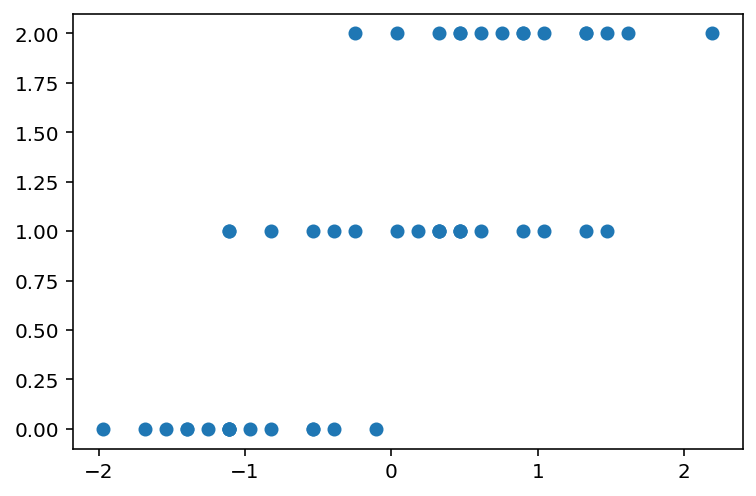

In [8]:
from sklearn.datasets import load_iris
import numpy as np
np.random.seed(0)
device = torch.device('cpu')
data = load_iris()
x_ = data['data']
y_ = data['target']
N_tr = 50
N_val = 150 - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [9]:
# params for plotting 
alpha=10
tau = alpha # Prior Precision
r = 0 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Epsilon = 0.2

In [10]:
# load data
epsilon = 0.1
emp_kde_betas = [.4, 0.5, 0.75, 1.]
var_betas = [0.001, 0.05, 0.1, 0.125]
emp_weights = []
emp_kls = []
for b in emp_kde_betas:
    emp_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_CLASSIFICATION/OLD/EMP/emp_beta_{b}_eps_{epsilon:.1f}.pkl', 'rb')))
    emp_kls.append(pkl.load(open(f'PickledStuff/BNN_BETA_CLASSIFICATION/OLD/EMP/hmc_kl_beta_{b}.pkl', 'rb')))
emp_kls = [t.detach() for t in emp_kls]
kde_weights = []
for b in emp_kde_betas:
    kde_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_CLASSIFICATION/OLD/KDE/kde_beta_{b}_eps_{epsilon:.1f}.pkl', 'rb')))

# var_weights = []
# var_kls = []
# for b in var_betas:
#     var_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_beta_{b}_eps_{epsilon:.1f}.pkl', 'rb')))
#     var_kls.append(pkl.load(open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_kl_beta_{b}.pkl', 'rb')))
# var_kls = [t.detach() for t in var_kls]

In [11]:
emp_train_lls = torch.zeros([0])
emp_val_lls = torch.zeros([0])
for w in emp_weights:
    emp_train_lls = torch.cat([emp_train_lls, compute_ll_from_weights(w, x_train, y_train)[None]])
    emp_val_lls = torch.cat([emp_val_lls, compute_ll_from_weights(w, x_val, y_val)[None]])

kde_train_lls = torch.zeros([0])
kde_val_lls = torch.zeros([0])
for w in kde_weights:
    kde_train_lls = torch.cat([kde_train_lls, compute_ll_from_weights(w, x_train, y_train)[None]])
    kde_val_lls = torch.cat([kde_val_lls, compute_ll_from_weights(w, x_val, y_val)[None]])

# var_train_lls = torch.zeros([0])
# var_val_lls = torch.zeros([0])
# for w in var_weights:
#     var_train_lls = torch.cat([var_train_lls, compute_ll_from_weights(w, x_train, y_train)[None]])
#     var_val_lls = torch.cat([var_val_lls, compute_ll_from_weights(w, x_val, y_val)[None]])

In [12]:
# load data
epsilon = 0.1
emp_kde_betas = [.4, 0.5, 0.75, 1.]
var_betas = [0.001, 0.05, 0.1, 0.125]
emp_exact_weights = []
for b in emp_kde_betas:
    emp_exact_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_CLASSIFICATION/OLD/EMP/HMC_beta_{b}.pkl', 'rb')))
emp_kls = [t.detach() for t in emp_kls]
kde_exact_weights = []
for b in emp_kde_betas:
    kde_exact_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_CLASSIFICATION/OLD/KDE/kde_exact_beta_{b}.pkl', 'rb')))

# var_exact_weights = []
# for b in var_betas:
#     var_exact_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_CLASSIFICATION/VAR/var_exact_beta_{b}.pkl', 'rb')))

In [13]:
emp_exact_train_lls = torch.zeros([0])
emp_exact_val_lls = torch.zeros([0])
for w in emp_exact_weights:
    emp_exact_train_lls = torch.cat([emp_exact_train_lls, compute_ll_from_weights(w, x_train, y_train)[None]])
    emp_exact_val_lls = torch.cat([emp_exact_val_lls, compute_ll_from_weights(w, x_val, y_val)[None]])

kde_exact_train_lls = torch.zeros([0])
kde_exact_val_lls = torch.zeros([0])
for w in kde_exact_weights:
    kde_exact_train_lls = torch.cat([kde_exact_train_lls, compute_ll_from_weights(w, x_train, y_train)[None]])
    kde_exact_val_lls = torch.cat([kde_exact_val_lls, compute_ll_from_weights(w, x_val, y_val)[None]])

# var_exact_train_lls = torch.zeros([0])
# var_exact_val_lls = torch.zeros([0])
# for w in var_exact_weights:
#     var_exact_train_lls = torch.cat([var_exact_train_lls, compute_ll_from_weights(w, x_train, y_train)[None]])
#     var_exact_val_lls = torch.cat([var_exact_val_lls, compute_ll_from_weights(w, x_val, y_val)[None]])

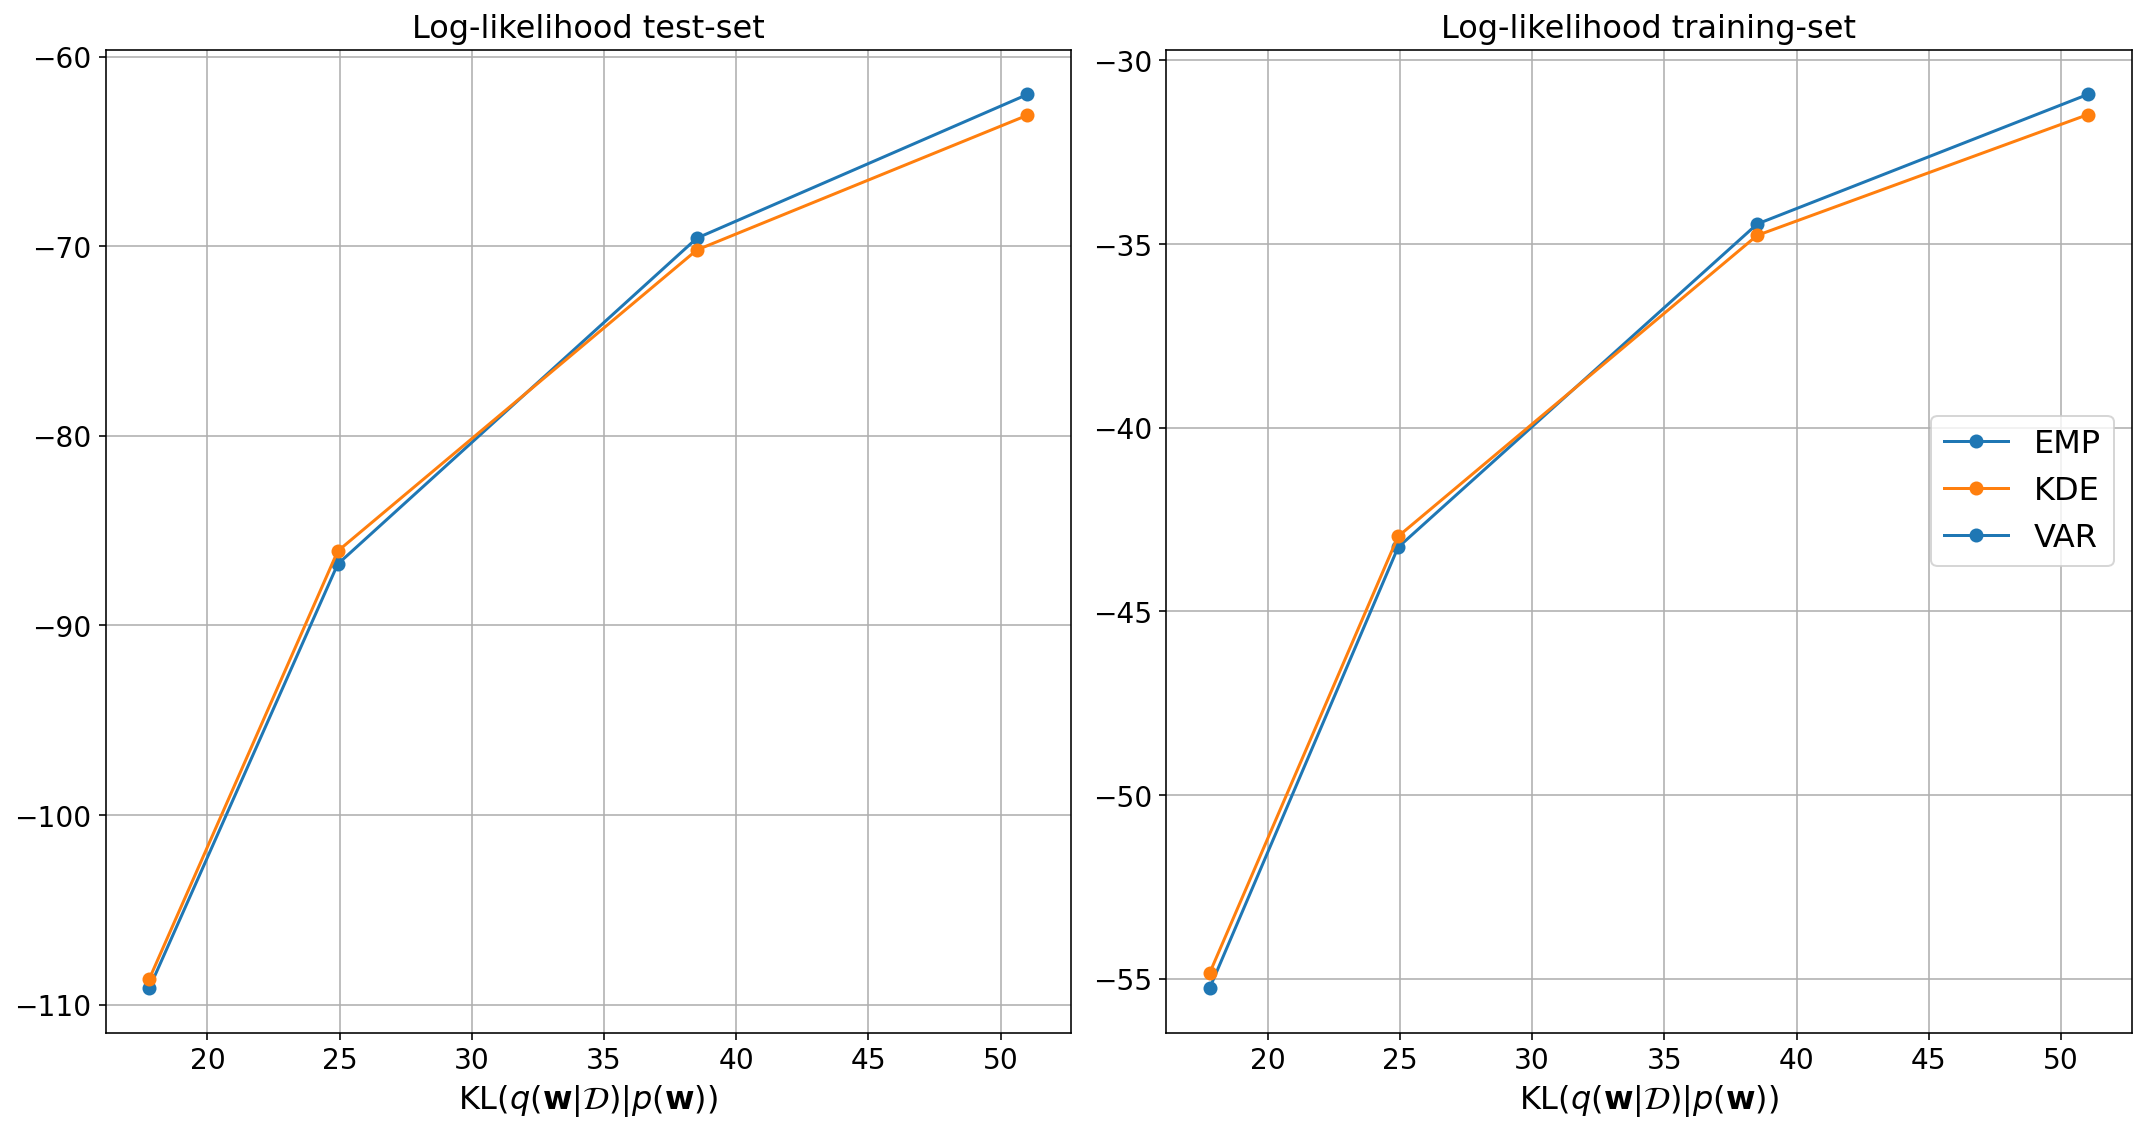

In [14]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
ax[0].plot(emp_kls, emp_val_lls, '-o')
ax[0].plot(emp_kls, kde_val_lls, '-o')
#ax[0].plot(var_kls, var_val_lls, '-o')
ax[0].grid()
ax[0].set_xlabel(r'$\operatorname{KL}\left(q(\mathbf{w}|\mathcal{D}) \| p(\mathbf{w})\right)$', fontsize=16)
ax[1].plot(emp_kls, emp_train_lls, '-o')
ax[1].plot(emp_kls, kde_train_lls, '-o')
#ax[1].plot(var_kls, var_train_lls, '-o')
ax[1].grid()
ax[1].set_xlabel(r'$\operatorname{KL}\left(q(\mathbf{w}|\mathcal{D}) \| p(\mathbf{w})\right)$', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['EMP', 'KDE', 'VAR'], loc = (0.9, 0.5), ncol=1, fontsize=16)
f.tight_layout()

In [15]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

In [17]:
emp_expected_coding_efficiency = [compute_expected_coding_efficiency(kl) for kl in emp_kls]

#var_expected_coding_efficiency = [compute_expected_coding_efficiency(kl) for kl in var_kls]

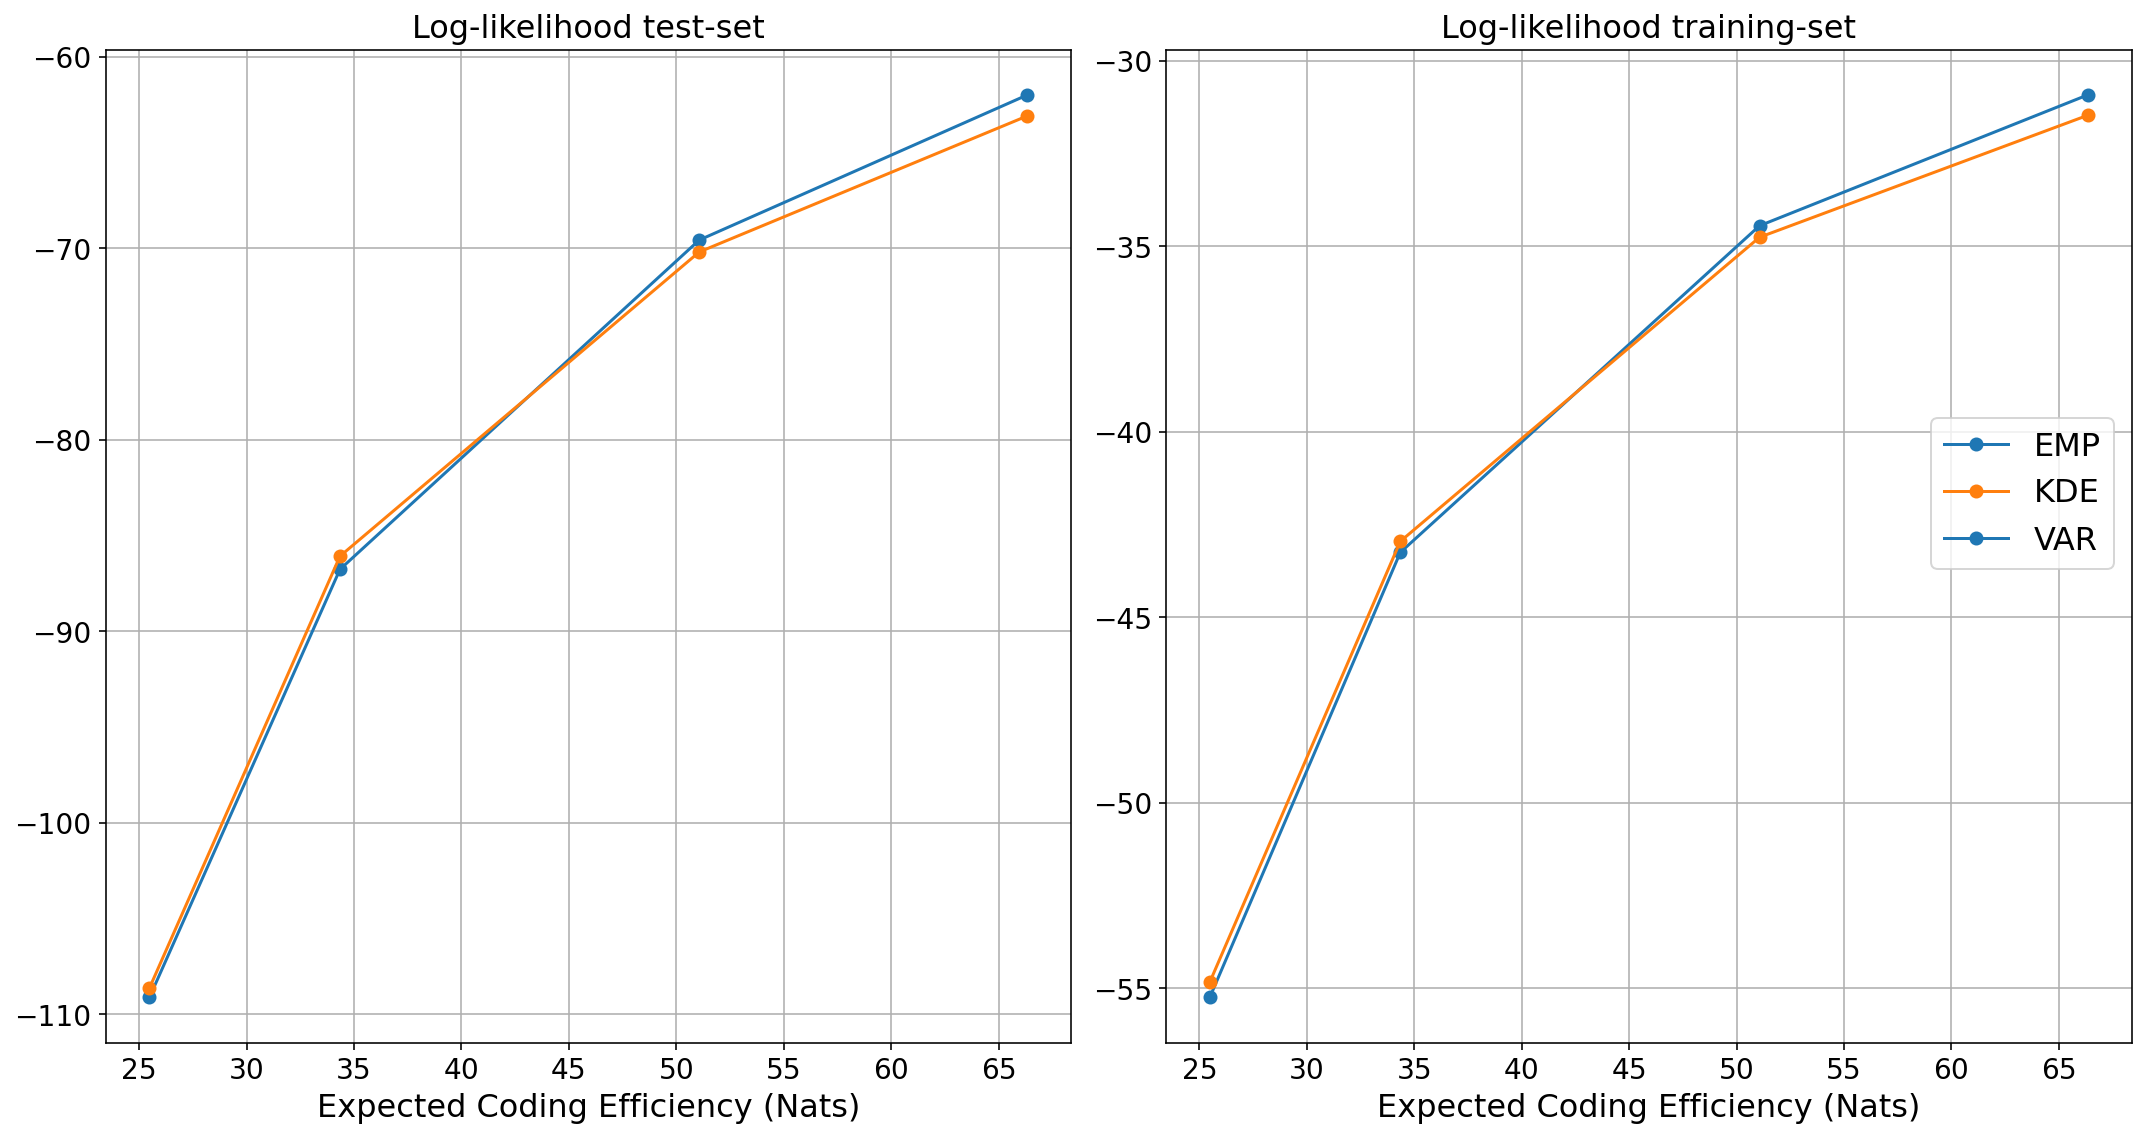

In [18]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
ax[0].plot(emp_expected_coding_efficiency, emp_val_lls, '-o')
ax[0].plot(emp_expected_coding_efficiency, kde_val_lls, '-o')
#ax[0].plot(var_expected_coding_efficiency, var_val_lls, '-o')
ax[0].grid()
ax[0].set_xlabel('Expected Coding Efficiency (Nats)', fontsize=16)
ax[1].plot(emp_expected_coding_efficiency, emp_train_lls, '-o')
ax[1].plot(emp_expected_coding_efficiency, kde_train_lls, '-o')
#ax[1].plot(var_expected_coding_efficiency, var_train_lls, '-o')
ax[1].grid()
ax[1].set_xlabel('Expected Coding Efficiency (Nats)', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['EMP', 'KDE', 'VAR'], loc = (0.9, 0.5), ncol=1, fontsize=16)
f.tight_layout()

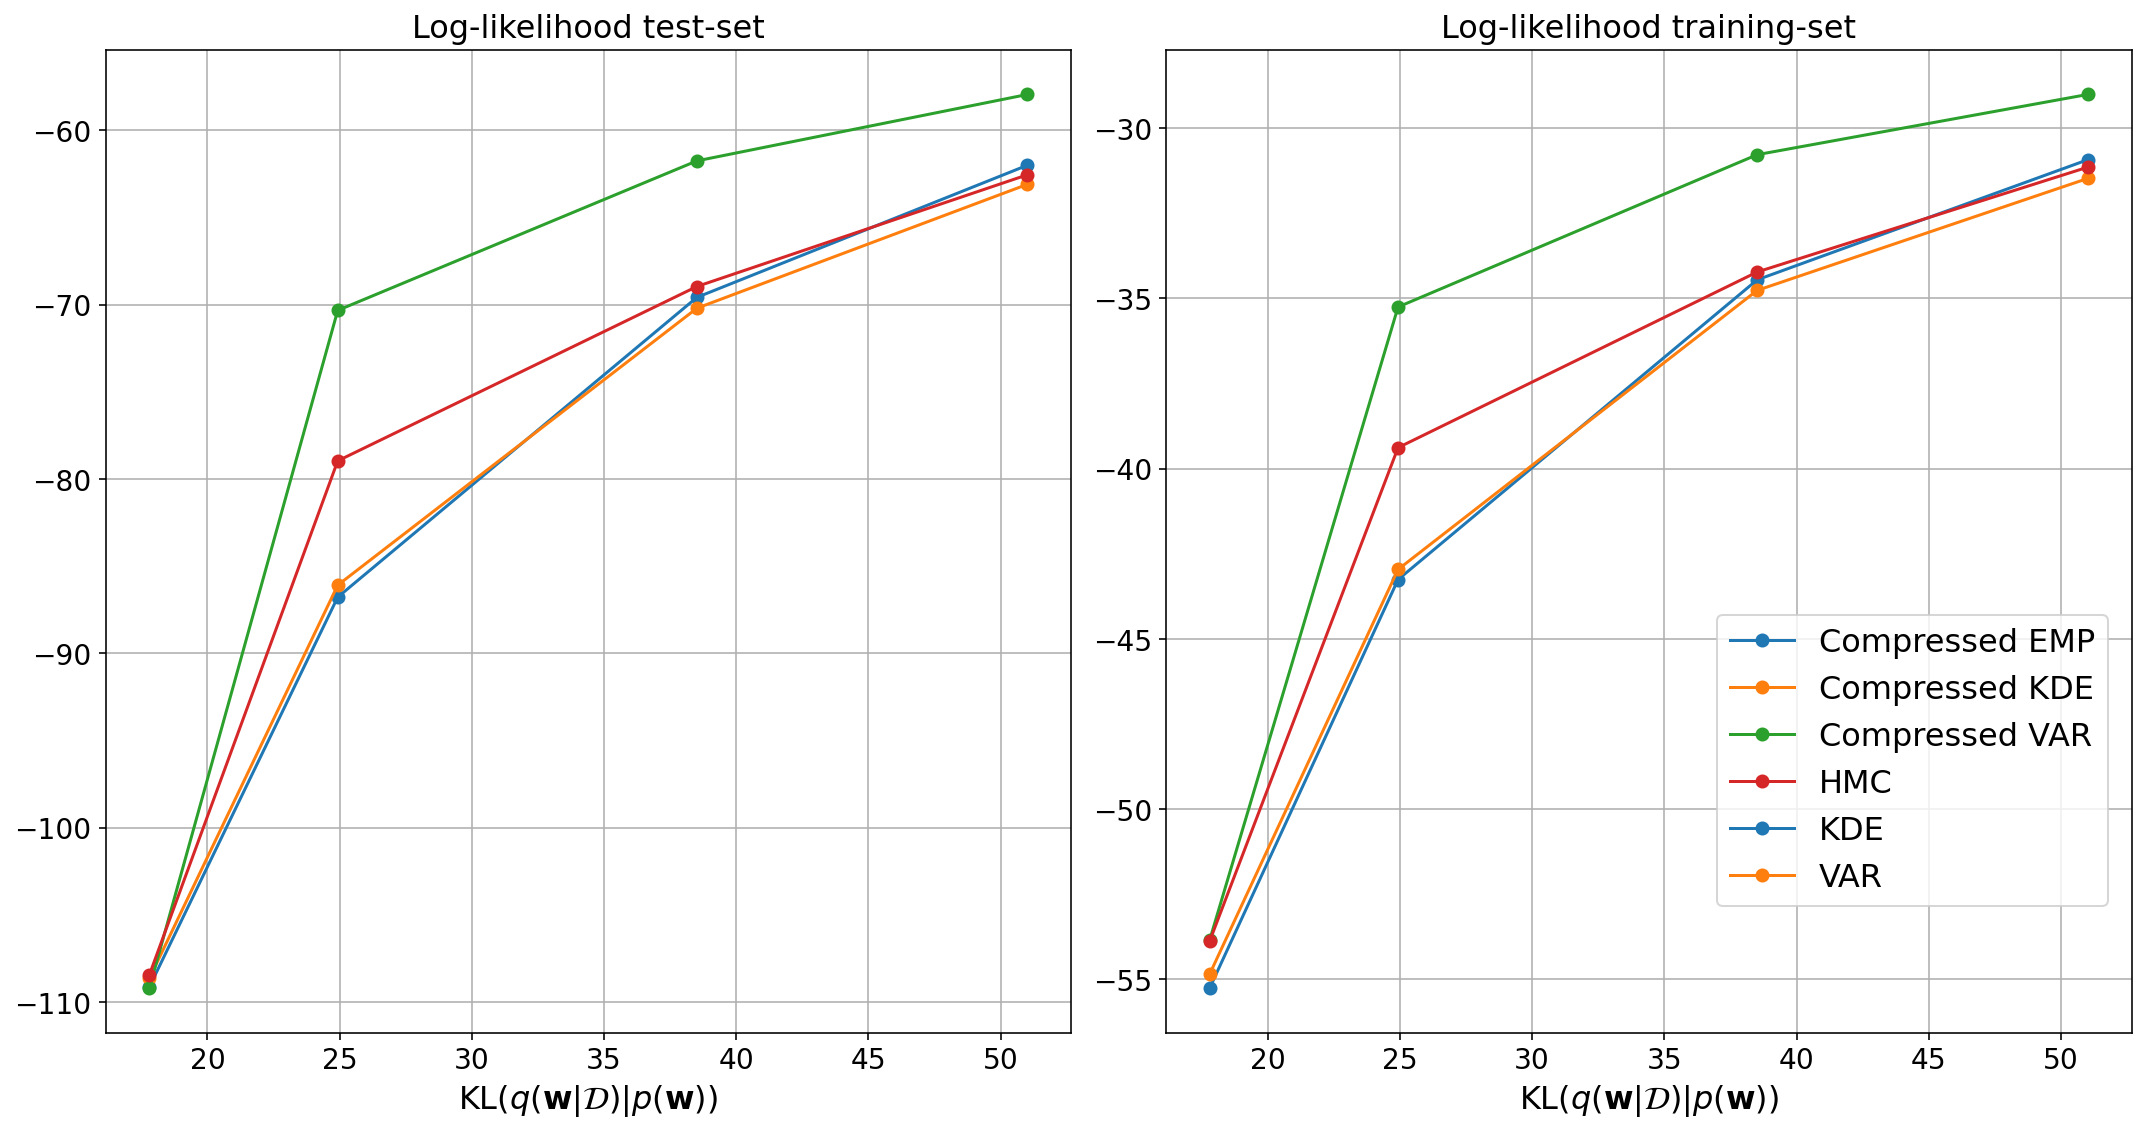

In [19]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
ax[0].plot(emp_kls, emp_val_lls, '-o')
ax[0].plot(emp_kls, kde_val_lls, '-o')
#ax[0].plot(var_kls, var_val_lls, '-o')
ax[0].plot(emp_kls, emp_exact_val_lls, '-o')
ax[0].plot(emp_kls, kde_exact_val_lls, '-o')
#ax[0].plot(var_kls, var_exact_val_lls, '-o')
ax[0].grid()
ax[0].set_xlabel(r'$\operatorname{KL}\left(q(\mathbf{w}|\mathcal{D}) \| p(\mathbf{w})\right)$', fontsize=16)
ax[1].plot(emp_kls, emp_train_lls, '-o')
ax[1].plot(emp_kls, kde_train_lls, '-o')
#ax[1].plot(var_kls, var_train_lls, '-o')
ax[1].plot(emp_kls, emp_exact_train_lls, '-o')
ax[1].plot(emp_kls, kde_exact_train_lls, '-o')
#ax[1].plot(var_kls, var_exact_train_lls, '-o')
ax[1].grid()
ax[1].set_xlabel(r'$\operatorname{KL}\left(q(\mathbf{w}|\mathcal{D}) \| p(\mathbf{w})\right)$', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['Compressed EMP', 'Compressed KDE', 'Compressed VAR', 'HMC', 'KDE', 'VAR'], loc = (0.8, 0.2), ncol=1, fontsize=16)
f.tight_layout()